Output Parsers in LangChain are highly useful tools primarily because they bridge the gap between the default unstructured text output of Large Language Models (LLMs) and the structured data required by external systems and complex application workflows.

The usefulness of Output Parsers can be understood through three main areas:

### 1. Enabling Structured Communication

The fundamental purpose of Output Parsers addresses the limitation of default LLM responses:

*   **Handling Unstructured Output:** When interacting with an LLM, the response returned is typically textual and, therefore, **unstructured**.
*   **System Incompatibility:** Since this response is unstructured, it **cannot be sent to other systems** like databases or APIs.
*   **Conversion to Structured Formats:** Output Parsers are classes in LangChain that help **convert raw LLM responses (textual responses) into structured formats** such as JSON, CSV, or Pydantic models. This conversion forces the LLM to deliver output with a specific structure or schema (like JSON), enabling communication with external systems.

### 2. Ensuring Consistency and Validation

Output Parsers ensure that the data received from the LLM is reliable, standardized, and ready for use in applications:

*   **Consistency:** They ensure the output data is consistent.
*   **Ease of Use:** They promote the **ease of use in applications**.
*   **Validation:** They provide mechanisms for data validation. For example, the Pydantic Output Parser uses Pydantic models not only to enforce a strict schema but also to enforce specific **data validation** and type safety (e.g., ensuring a field is an integer or meets a specific constraint).

### 3. Streamlining Workflows and Model Compatibility

Output Parsers simplify the overall application development process in LangChain, especially when dealing with complex pipelines or varying LLM capabilities:

*   **Required for Some Models:** They are crucial for working with models (often open-source models) that **cannot by default provide structured output**.
*   **Universal Applicability:** Although some advanced models can provide structured output, Output Parsers offer a seamless way to derive structured output from **any type of LLM** (whether they can or cannot provide structured output by default), maintaining compatibility across different systems, including OpenAI, Hugging Face, or locally downloaded models.
*   **Simplifying Chains:** Parsers are highly useful when working with **Chains** (pipelines of steps) in LangChain.
    *   Default LLM responses include a lot of **metadata** (like token usage) alongside the actual content. The parser (like the String Output Parser) allows developers to **directly extract the actual textual response** without manually handling the metadata or calling `result.content`.
    *   By automatically extracting the necessary output (e.g., a simple string) and passing it to the next step, parsers allow the entire multi-step process to be built into a **single, clean chain** (pipeline).


### Understanding Output Parsers

**Definition and Purpose:**
Output Parsers in LangChain are classes that convert raw, textual LLM responses into structured formats, such as JSON, CSV, or Pydantic models. They ensure consistency, validation, and ease of use in applications.

**Applicability:**
Output Parsers are crucial for working with models that **cannot** inherently provide structured output. However, they can also be used effectively with models that **can** provide structured output (like GPT models), offering a seamless experience across different LLMs.

---

### The Four Key Output Parsers

The source focuses on four widely used output parsers in LangChain.

#### 1. String Output Parser

The String Output Parser is the simplest parser.

| Feature | Description |
| :--- | :--- |
| **Function** | Takes the LLM response and converts it to a standard Python string. |
| **Extraction** | It directly extracts the textual response content (the *actual* answer), bypassing the metadata often returned by LLMs (e.g., token usage). This removes the need to manually extract `result.content`. |
| **Primary Use Case** | Highly useful when working with **Chains** in LangChain, as it simplifies the pipeline by automatically converting the model's output into a usable string for the next step. |

**Example Code Structure (Using Chains):**
The String Output Parser simplifies multi-step processes (like generating a detailed report and then summarizing it) into a single, clean pipeline.

```python
# Create the parser
parser = StringOutputParser()

# Form the Chain (Pipeline)
# Template 1 (Detailed Report) -> Model -> Parser (extracts string) ->
# Template 2 (Summary) -> Model -> Parser (extracts final summary)
chain = template_1 | model | parser | template_2 | model | parser

# Invoke the chain
result = chain.invoke({"topic": "Black Hole"})
```

#### 2. JSON Output Parser

The JSON Output Parser is the quickest way to force an LLM to send its output in JSON format.

| Feature | Description |
| :--- | :--- |
| **Function** | Instructs the LLM to return data in JSON format. |
| **Mechanism** | The parser uses the `.get_format_instructions()` function to generate specific instructions (e.g., "Return a JSON object") which are injected into the prompt template as a `partial_variable`. |
| **Output Type** | The parser converts the LLM's JSON string response into a Python **dictionary**. |
| **Limitation** | **Does not enforce a schema**. The LLM dictates the internal structure of the JSON object, meaning you cannot guarantee specific key names (e.g., requiring keys like `fact_1`, `fact_2`). |

**Example Code Structure (Template and Chain):**

```python
parser = JsonOutputParser()
# Format instructions are injected into the Prompt Template
template = PromptTemplate(
    template="Give me the name, age, and city of a fictional person. \n{format_instruction}",
    partial_variables={"format_instruction": parser.get_format_instructions()}
)
chain = template | model | parser
result = chain.invoke({}) # Use blank dictionary if no input variables
```

#### 3. Structured Output Parser

The Structured Output Parser overcomes the JSON Output Parser's inability to define an expected structure.

| Feature | Description |
| :--- | :--- |
| **Function** | Extracts structured JSON data based on **predefined field schemas**. It enforces a specific schema on the LLM's output. |
| **Schema Definition** | Schemas are defined using the `ResponseSchema` class (imported from `langchain`, not `langchain_core`). |
| **Parser Creation** | The parser is instantiated using the schemas via `StructuredOutputParser.from_response_schemas()`. |
| **Limitation** | **Does not allow data validation**. For example, you can enforce that an `Age` field exists, but you cannot enforce that the value must be an integer or greater than 18. If the LLM returns "35 years" (a string), the parser accepts it unless manually processed. |

**Example Code Structure (Schema Definition):**

```python
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

# 1. Define the Schema List
schemas = [
    ResponseSchema(name="fact_1", description="Fact one about the topic"),
    ResponseSchema(name="fact_2", description="Fact two about the topic"),
    # ...
]

# 2. Create the Parser
parser = StructuredOutputParser.from_response_schemas(schemas)

# 3. Use in Chain (similar to JSON Output Parser, injecting format instructions)
# ...
```

#### 4. Pydantic Output Parser

The Pydantic Output Parser is the most robust option, addressing the validation limitation of the Structured Output Parser.

| Feature | Description |
| :--- | :--- |
| **Function** | Uses Pydantic models to enforce **strict schema validation** when processing LLM responses. It combines structured JSON output with data validation. |
| **Schema Definition** | The schema is defined by creating a Pydantic `BaseModel` class. This allows defining specific data types (`str`, `int`) and constraints (e.g., `gt=18` for age). |
| **Benefits** | Provides **strict schema enforcement**, **type safety**, and **easy validation**. Even if the LLM output is slightly incorrect, Pydantic can often apply type coercion. |

**Example Code Structure (Pydantic Model and Parser):**

```python
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser

# 1. Define the Pydantic Object (Schema)
class Person(BaseModel):
    name: str = Field(description="Name of the person")
    # Enforce integer type AND a constraint (>18)
    age: int = Field(description="Age of the person", gt=18)
    city: str = Field(description="Name of the city")

# 2. Create the Parser using the BaseModel
parser = PydanticOutputParser(pydantic_object=Person)

# 3. Use in Chain (similar to previous structured parsers)
# ...
```

### Summary of Parser Capabilities

| Parser Type | Output Format | Schema Enforcement? | Data Validation? | Primary Use Case |
| :--- | :--- | :--- | :--- | :--- |
| **String Output Parser** | String (Text) | No | No | Streamlining multi-step Chains |
| **JSON Output Parser** | JSON (Dictionary) | No (LLM decides structure) | No | Quickest way to request JSON output |
| **Structured Output Parser** | Structured JSON | Yes (via `ResponseSchema`) | No | Enforcing specific key structures in JSON |
| **Pydantic Output Parser**| Validated Structured JSON | Yes (via `BaseModel`) | Yes (via Pydantic constraints) | Achieving maximum control over structure and data integrity |

***

**Analogy:**

Think of LLM output as raw clay.

*   The **String Output Parser** just makes sure the clay is taken out of the machine cleanly so you can use it in the next step.
*   The **JSON Output Parser** forces the clay into a standard block shape, but you can't control what details (the internal facets) the block has.
*   The **Structured Output Parser** forces the clay into a specific mold (the schema), ensuring the overall external structure is correct.
*   The **Pydantic Output Parser** forces the clay into that specific mold AND checks that the material inside is exactly what you ordered (e.g., verifying it's hard ceramic, not soft putty), guaranteeing both structure and quality.

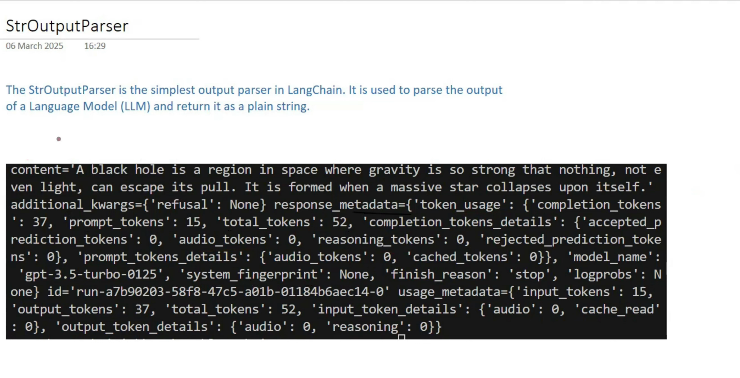

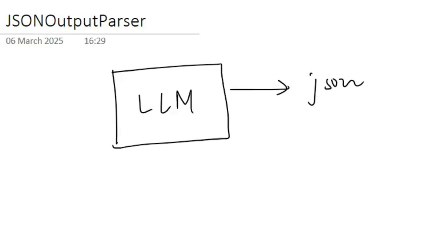

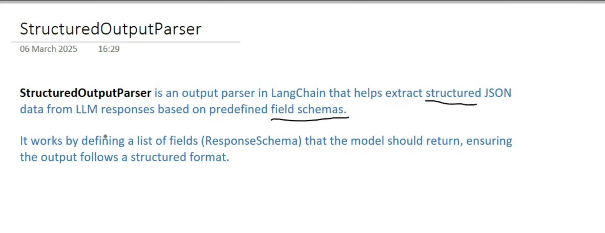

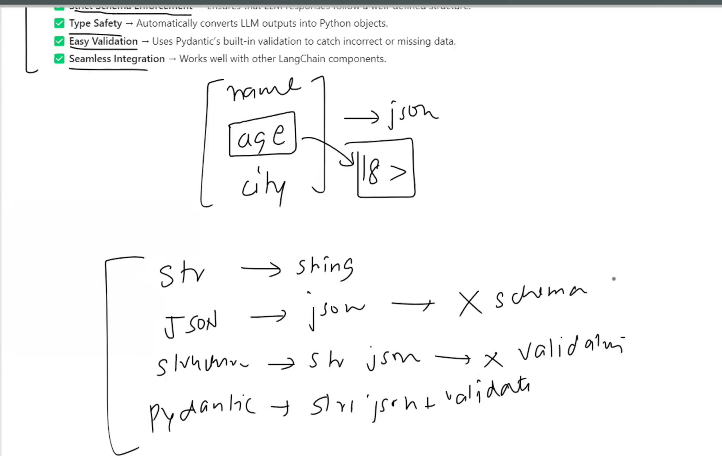



---

### Interview Q&A on LangChain Output Parsers

#### Q1: What is the primary problem Output Parsers solve, and how does this relate to the concept of Structured Output?

The fundamental problem Output Parsers solve is handling the **unstructured nature** of standard Large Language Model (LLM) responses.

1.  **Unstructured Responses:** When you interact with an LLM, the response it returns is typically **textual** and therefore unstructured.
2.  **System Incompatibility:** An unstructured response **cannot be sent to other systems**, such as databases or APIs, which require data in a specific format.
3.  **Structured Output Necessity:** Output Parsers enable **Structured Output**, which forces the LLM to deliver a response with a specific structure or schema (like JSON).
4.  **Definition:** Output Parsers are classes in LangChain that help **convert raw, textual LLM responses into structured formats** like JSON, CSV, or Pydantic models. They ensure **consistency, validation, and ease of use** in applications.

Output Parsers are particularly helpful for models that **cannot by default provide structured output** (like many open-source models), although they can also be used seamlessly with models that *can* provide structured output.

---

#### Q2: Can you outline the four main Output Parsers in LangChain and their core functions?

The sources focus on four of the most commonly used parsers:

1.  **String Output Parser:**
    *   **Function:** Takes the raw LLM response and converts it into a standard Python **string**.
    *   **Use Case:** Highly useful when working with **Chains** (pipelines) in LangChain, as it automatically extracts the textual content, removing the need to manually extract `result.content` from the metadata-heavy LLM response.

2.  **JSON Output Parser:**
    *   **Function:** Forces the LLM to return data in **JSON format**.
    *   **Mechanism:** Uses the `.get_format_instructions()` function to generate specific output instructions (e.g., "Return a JSON object") which are injected into the prompt template.
    *   **Output Type:** Converts the JSON string response into a Python **dictionary**.

3.  **Structured Output Parser:**
    *   **Function:** Extracts structured JSON data based on **predefined field schemas**.
    *   **Schema Definition:** Schemas are defined using the `ResponseSchema` class.
    *   **Benefit:** Enables **schema enforcement**, allowing you to dictate the structure of the keys (e.g., requiring keys like `fact_1`, `fact_2`, etc.).

4.  **Pydantic Output Parser:**
    *   **Function:** A structured output parser that leverages Pydantic models to enforce **strict schema validation** on LLM responses.
    *   **Schema Definition:** Schemas are defined by creating a Pydantic `BaseModel`.
    *   **Benefit:** Provides **strict schema enforcement, type safety, and easy validation**.

---

#### Q3: What is the main limitation of the JSON Output Parser, and how do the Structured and Pydantic Parsers overcome it?

The major limitation of the **JSON Output Parser** is that it **does not enforce a specific schema**. The LLM decides the internal structure of the JSON object, meaning you cannot guarantee specific keys or nesting structures (e.g., ensuring keys are `fact_1`, `fact_2`, instead of a list under a single key).

**Structured Output Parser Solution (Schema Enforcement):**
The **Structured Output Parser** overcomes this by allowing you to **provide a schema** (using `ResponseSchema` objects). This forces the LLM to produce structured JSON data based on those predefined field schemas, enforcing a structure.

**Pydantic Output Parser Solution (Validation):**
The **Structured Output Parser** itself still has a limitation: it **cannot perform data validation**. For instance, it can enforce an 'Age' field exists, but not that its value must be an integer, or that it must be greater than 18.

The **Pydantic Output Parser** resolves the validation issue. By using a Pydantic `BaseModel` for schema definition, you can apply **data constraints** and enforce **strict data types** (like `int` or `str`), providing **type safety** and robust validation to the output.

---

#### Q4: When building a multi-step application in LangChain, why is the String Output Parser preferred over manually extracting content?

The String Output Parser is crucial for streamlining processes, especially when using **Chains**.

1.  **Raw Output Complexity:** When an LLM is invoked, the result often contains the textual content along with substantial **metadata** (like token usage, completion usage, etc.).
2.  **Manual Extraction:** Without a parser, a developer must manually extract the necessary text using `result.content`.
3.  **Chain Simplification:** The String Output Parser automatically takes the raw LLM response, extracts **only the actual textual response**, and converts it into a clean string.
4.  **Pipeline Creation:** This capability allows complex sequences of operations (e.g., Prompt 1 $\rightarrow$ Model $\rightarrow$ *Extracted String* $\rightarrow$ Prompt 2 $\rightarrow$ Model $\rightarrow$ Parser) to be converted into a **single, clean pipeline**. This is much cleaner and easier to manage than manually handling intermediate results and calling `.content` repeatedly.